## Non stationary environment learning 
How to implement a non stationary environment and how to learn in it. 


In [7]:
##Environment import 
import numpy as np
class Environment():
    def __init__(self, n_arms, probabilities):
        self.n_arms = n_arms
        self.probabilities = probabilities

    def round(self, pulled_arm):
        return np.random.binomial(1, self.probabilities[pulled_arm])

In [12]:
import numpy as np 

class Non_Stationary_Environment(Environment):
    def __init__(self, n_arms, probabilities, horizon):
        super().__init__(n_arms, probabilities)
        self.t = 0
        n_phases = len(self.probabilities)
        self.phases_size = horizon/n_phases
    
    def round(self, pulled_arm):
        #Periodic phases of equal lenght
        current_phase = int(self.t / self.phases_size) 
        p = self.probabilities[current_phase][pulled_arm]
        reward = np.random.binomial(1, p)
        self.t +=  1
        return reward      

### Sliding window thompson sampling algortithm.
It's based on the TS learner class

In [13]:
import numpy as np 

class Learner():
    def __init__(self, n_arms):
        self.n_arms = n_arms 
        self.t = 0  #Time 
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = []
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)

class TS_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))

    def pull_arm(self):
        return np.argmax(np.random.beta(self.beta_parameters[: , 0], self.beta_parameters[:, 1]))

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm , 1] + 1 - reward

In [17]:
class SWTS_Learner(TS_Learner):
    def __init__(self, n_arms, window_size):
        super().__init__(n_arms)
        self.window_size = window_size 
        self.pulled_arms = np.array([])
    
    def update(self, pulled_arm, rewarc):
        self.t += 1 
        self.update_observations(pulled_arm, reward)
        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)
        for arm in range(self.n_arms):
            n_samples = np.sum(self.pulled_arms[-self.window_size:] == arm)
            cum_rew = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
            self.beta_parameters[arm, 0] = cum_rew + 1.0 
            self.beta_parameters[arm, 1] = n_samples - cum_rew + 1.0

In [19]:
import matplotlib.pyplot as plt

n_arms = 4 
n_phases = 4
p = np.array([[0.15, 0.1, 0.2, 0.35], [0.45, 0.21, 0.2, 0.35],
  [0.1, 0.1, 0.5, 0.15], [0.1 , 0.21, 0.1, 0.15]])
T = 500
phases_len = int(T/n_phases)
n_experiments = 100
ts_rewards_per_experiment = []
swts_rewards_per_experiment = []
window_size = int(T**0.5)

for e in range(n_experiments):
    ts_env = Non_Stationary_Environment(n_arms, probabilities = p, horizon = T)
    ts_learner = TS_Learner(n_arms = n_arms)

    swts_env = Non_Stationary_Environment(n_arms, probabilities = p, horizon = T) 
    swts_learner = SWTS_Learner(n_arms = n_arms, window_size = window_size)

    for t in range(T):
        pulled_arm = ts_learner.pull_arm()
        reward = ts_env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)


        pulled_arm = swts_learner.pull_arm()
        reward = swts_env.round(pulled_arm)
        swts_learner.update(pulled_arm, reward)
    
    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    swts_rewards_per_experiment.append(swts_learner.collected_rewards)

ts_instantaneus_regret = np.zeros(T)
swts_instantaneus_regret = np.zeros(T)
opt_per_phase = p.max(axis = 1)
opt_per_round = np.zeros(T)

for i in range(n_phases):
    t_index = range(i*phases_len, (i+1)*phases_len)
    opt_per_round[t_index] = opt_per_phase[i]
    ts_instantaneus_regret[t_index] = opt_per_phase[i] - np.mean(ts_rewards_per_experiment, axis = 0)[t_index]
    swts_instantaneus_regret[t_index] = opt_per_phase[i] - np.mean(swts_rewards_per_experiment, axis = 0)[t_index]

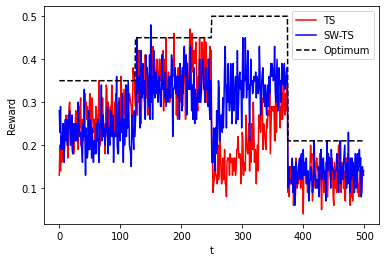

In [21]:
plt.figure(0)
plt.plot(np.mean(ts_rewards_per_experiment, axis = 0), 'r')
plt.plot(np.mean(swts_rewards_per_experiment, axis = 0), 'b')
plt.plot(opt_per_round, 'k--')
plt.legend(['TS', 'SW-TS', 'Optimum'])
plt.ylabel('Reward')
plt.xlabel('t')
plt.show()

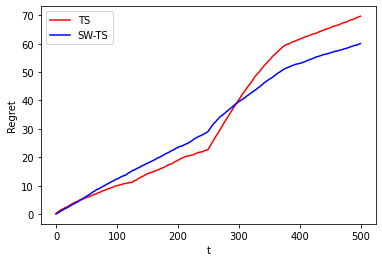

In [23]:
plt.figure(1)
plt.plot(np.cumsum(ts_instantaneus_regret), 'r')
plt.plot(np.cumsum(swts_instantaneus_regret), 'b')
plt.legend(['TS', 'SW-TS'])
plt.ylabel('Regret')
plt.xlabel('t')
plt.show()